(mix_propagation)=
# Mix uncertainty propagation

Different uncertainty models exist to represent uncertainty. It is suggested that aleatory and epistemic uncertainties should have been characterised and propagated distinctly due to their nature and implication. P-box manifests both uncertainties in one structure. In practice, engineering anlyses typically involve uncertainties in various kinds, and therefore deal with *mix uncertainty propagation* which is typically seen in two forms: pbox propagation or propagation of a mixure of variables of different uncertainty types.

uncertain numbers are most suitable for working with mixed uncertainty problems since the they allow a consistent interface to handle various uncertainties. This notebook will demonstrate two implementations: (i) a low-level one for extra controls; and (ii) a high-level one for simplicity.

You will discover that calling signature is the same.

```{seealso}
There is an increasing awareness, among the scientific computation community, of the differentiation of aleatory and epistemic uncertainty and that different methods are needed for characterisation and propagation. See {ref}`epistemic_propagation` for the propagation of epistemic uncertainty and {ref}`aleatory_propagation` for propagation of aleatory uncertainty.
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyuncertainnumber as pun
from pyuncertainnumber import pba

## P-box propagation

#### low-level implementation

In [2]:
def f(x):
    """a universal signature that takes both iterable (1d) and matrix (2d) inputs """

    if isinstance(x, np.ndarray):  # foo_vectorised signature
        if x.ndim == 1:
            x = x[None, :]
        return x[:, 0] ** 3 + x[:, 1] + x[:, 2]
    else:
        return x[0] ** 3 + x[1] + x[2]  # foo_iterable signature

```{note}
the importance of inter-variable dependency
```

In [3]:
a = pba.normal([2,3], [1])
b = pba.normal([10,14], [1])
c = pba.uniform([4,5], [10,11])

with pba.dependency('p'):  # perfect dependency
    z_p = f([a,b,c])

with pba.dependency('f'):  # Frechet dependency
    z_f = f([a,b,c])

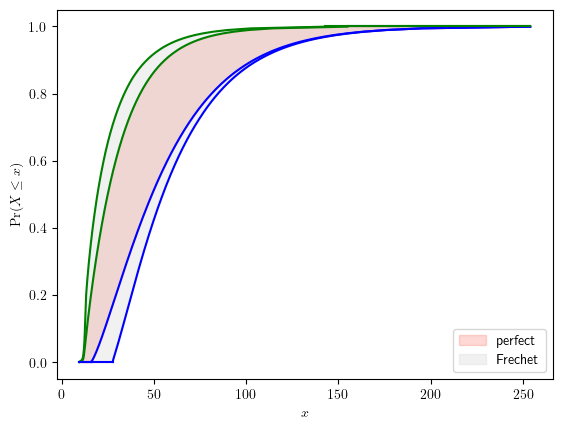

In [4]:
fig, ax = plt.subplots()
z_p.plot(nuance='curve', ax=ax, fill_color='salmon', label='perfect')
z_f.plot(nuance='curve', ax=ax, label='Frechet')
plt.show()

```{tip}
intrusive signature: using interval Monte Carlo, consider Gaussian copula.  
```

In [5]:
''' interval Monte Carlo '''
corre_matrix = np.array([[1, 0.5, 0.3], [0.5, 1, 0.4], [0.3, 0.4, 1]])
de = pba.Dependency(family='gaussian', corr=corre_matrix)

t_gau_copula = pun.interval_monte_carlo(
    vars=[a,b,c], 
    func=f, 
    dependency=de,
    interval_strategy='direct', 
    n_sam=30_000
) 

Pbox ~ (range=[11.129, 252.204], mean=[34.942, 60.992], var=[457.970, 1668.588])


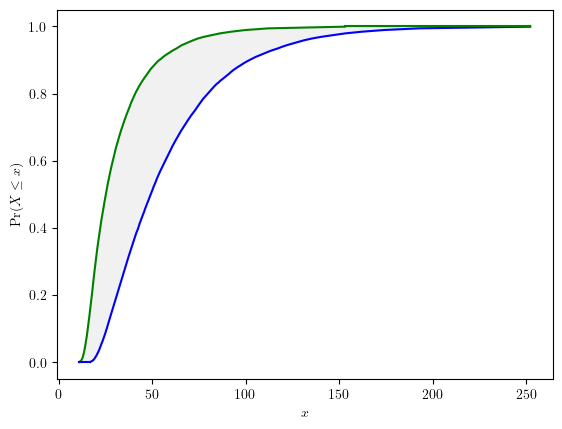

In [6]:
pba.inspect_pbox(t_gau_copula)

In [7]:
''' slicing '''
a = pba.normal([2,3], [1])
b = pba.normal([10,14], [1])
c = pba.uniform([4,5], [10,11])

test_ = pun.slicing(
    vars=[a,b,c], 
    func=f, 
    interval_strategy='direct', 
    dependency = de,
    outer_discretisation=True,
    n_slices=100
) 

Pbox ~ (range=[12.995, 172.590], mean=[32.912, 58.935], var=[224.453, 1333.884])


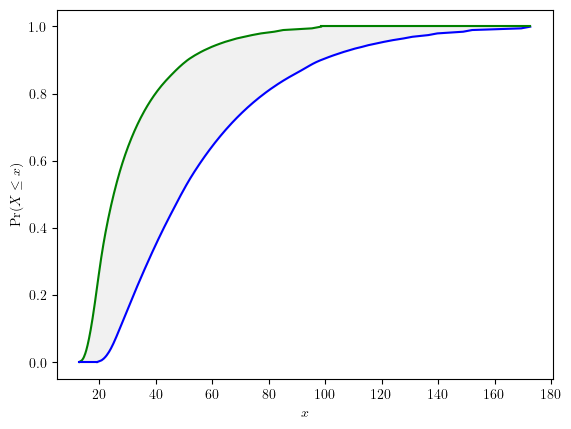

In [8]:
pba.inspect_pbox(test_)

## A mixture of uncertainties 

`pyuncertainnumber` allows you to compute with uncertainty without worrying about the type. This makes the calculation involving a mixture of uncertainty kinds very easy. Below illustrate the example when one has an interval, a probability distribution and also a p-box.

```{tip}
In terms of a non-intrusive context, one can also use the [double Monte Carlo](https://pyuncertainnumber.readthedocs.io/en/latest/autoapi/pyuncertainnumber/propagation/mixed_uncertainty/mixed_up/index.html#pyuncertainnumber.propagation.mixed_uncertainty.mixed_up.double_monte_carlo) (a.k.a nested Monte Carlo).
```

In [9]:
# the example in the readme.

a = pba.I(1, 5)  # interval
b = pba.normal([10,14], [1])  # pbox
c = pba.uniform(4, 11)  # distribution

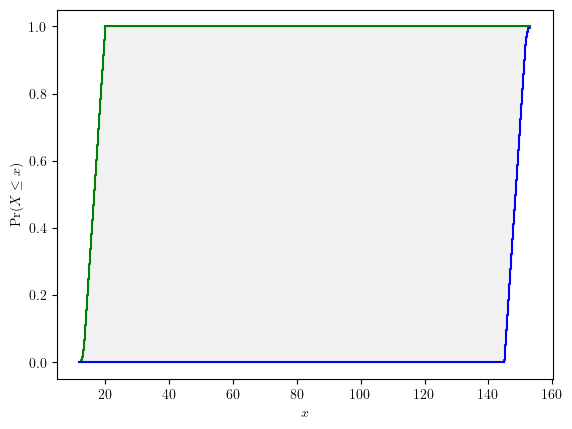

In [10]:
f([a, b, c]).display()

## high-level implementation with `uncertain numbers`

As described in {ref}`what_is_uncertain_number`, the concept of uncertain numbers encompass intervals, distributions, p-boxes, Dempster Shafer structures, and real numbers. Therefore, the framework of uncertain numbers can natively handle mixed uncertainty problem, and it is no longer mixed any more.

In [11]:
a = pun.I(1, 5)  # interval
b = pun.normal([10,14], [1])  # pbox
c = pun.uniform(4, 11)  # distribution

In [12]:
p = pun.Propagation(
    vars = [a,b,c],
    func = f,
    method = "slicing",
    interval_strategy='endpoints'
)

INFO: mixed uncertainty propagation


In [13]:
un_p = p.run(n_slices=50)

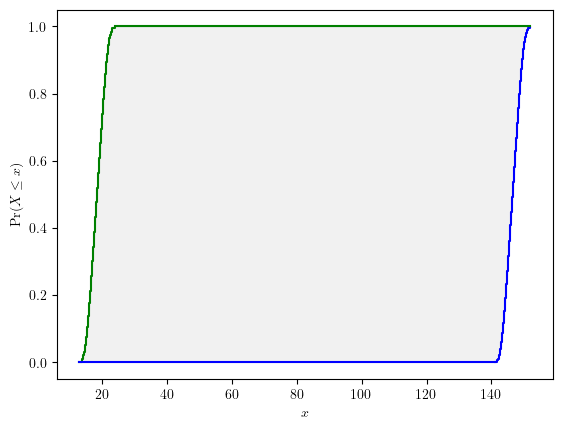

In [14]:
un_p.display()

In [15]:
un_p

UncertainNumber(essence='pbox', _construct=Pbox ~ (range=[13.062, 151.938], mean=[20.587, 147.927], var=[1.280, 4356.734]), nominal_value=84.257)

In [16]:
# surroaget to propagte pbox is udnerway